In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [ ]:
animals = pd.read_csv('../data/zoo.csv')
# animals.drop(['animal_name'], axis=1, inplace=True)

# animal_names = pd.read_csv('../data/zoo.csv').animal_name


classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

animals = animals.merge(classes)

animal_names = animals[['animal_name', 'class_name']]

In [7]:
animals = pd.read_csv('../data/zoo.csv')
# animals.drop(['animal_name'], axis=1, inplace=True)

classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

animals = animals.merge(classes)

In [8]:
targets = animals.class_name.value_counts().index
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name', 'legs'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs, drop_first=True).loc[:, 1:]
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]

animals = animals.drop('legs', 1).join(dummy_legs)
animal_names = animals.animal_name

X = animals[features].join(dummy_legs)
y = animals.class_type.as_matrix()

## Model Preparation

In [35]:
targets = animals.class_name.unique()
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name', 'legs'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs, drop_first=True)
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]

X = animals[features].join(dummy_legs)
y = animals.class_type.as_matrix()

## Define qualitative colors for plotting each class

Trying to think of some more intuitive colors for each of the classes....

Mammals - Brown

Fish - Blue

Reptiles - Black

Amphibians - Green

Invertebrates - Gray

Bug - Pink

Bird - Red

In [9]:
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

cmap = cm.get_cmap('tab10', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]

# Is our data linearly separable?

## Linear Discriminant Analysis + Computational Geometry
The model will basically draw lines through the outer points of each class in lower-dimensional space to create the smallest possible polygon that encapsulates every point in the class. If any of the shapes overlap, the data is not linearly separable based on the x- and y-components. To detect overlap, we use what's called the convex hull algorithm. The picture below demonstrates this concept:


![img](../img/linear_separability_demonstration.jpg)

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import pylab as pl

In [146]:
animal_names

,animal_name,class_name
0,aardvark,Mammal
1,antelope,Mammal
2,bear,Mammal
3,boar,Mammal
4,buffalo,Mammal
5,calf,Mammal
6,cavy,Mammal
7,cheetah,Mammal
8,deer,Mammal
9,dolphin,Mammal


In [179]:
def plot_decomp_samples(X, y, est='LDA'):
    est = est.lower()
    if est == 'lda':
        X_r = LDA(n_components=2).fit_transform(X, y)
    elif est == 'pca':
        X_r = PCA(n_components=2).fit_transform(X, y)
    else:
        raise ValueError('est must be "pca" or "lda"')
        
    plt.clf()
    plt.figure(figsize = (10, 6))
    targets = classes.class_name
    plt.title(est.upper() + ' Projection of Animal Features')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')

    for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
        bucket = X_r[y == i, :]
        try:
            hull = ConvexHull(bucket) 
            for j in hull.simplices:
                plt.plot(bucket[j,0], bucket[j,1], color)
        except:
            hull = None

        coords = list(zip(bucket[:,0], bucket[:,1], animals[animals.class_type == i].index))
        plt.scatter(bucket[:, 0], bucket[:, 1], color=color, alpha=.8, lw=.5, label=target)
#         for x1,x2,ind in coords:
#             pl.text(x1, x2, str(ind), color='black', fontsize=12)

    plt.legend()
    plt.show()

In [180]:
animals[animals.class_name == 'Amphibian']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
92,frog1,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0,5,Amphibian
93,frog2,0,0,1,0,0,1,1,1,1,1,1,0,4,0,0,0,5,Amphibian
94,newt,0,0,1,0,0,1,1,1,1,1,0,0,4,1,0,0,5,Amphibian
95,toad,0,0,1,0,0,1,0,1,1,1,0,0,4,0,0,0,5,Amphibian


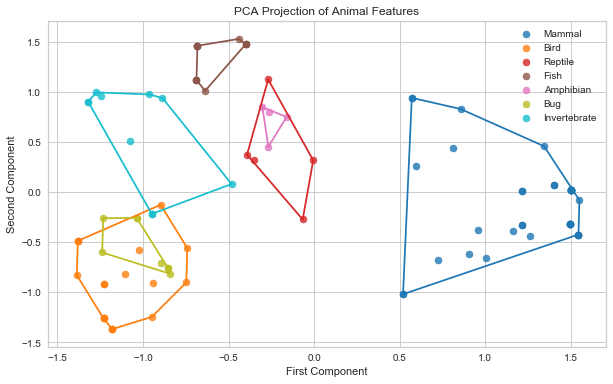

In [182]:
plot_decomp_samples(X.drop('animal_name', 1), y, 'pca')

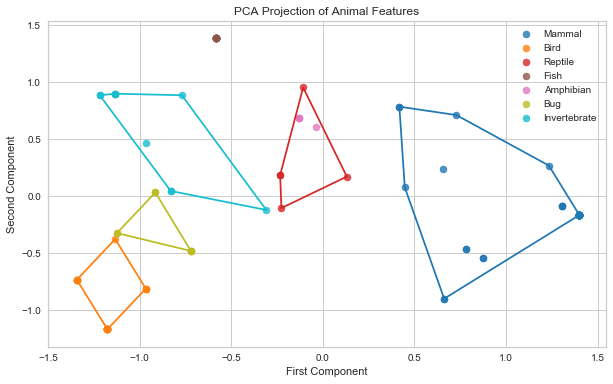

In [184]:
plot_decomp_samples(X.drop('animal_name', 1)[important_features], y, 'pca')

In [41]:
animal_names.iloc[93]

animal_name        frog2
class_name     Amphibian
Name: 93, dtype: object

Although the LDA visualization looks better, PCA tends to perform better when the number of classes in each sample is small, which is the case for us. For this reason we will consider a PCA-based classification.

### Single Layer Perceptron

If our data is linearly separable, then we should be able to run it through a convergent single layer perceptron. A single layer perceptron will only converge if the input vectors are linearly separable. In this state, all input vectors would be classified correctly indicating linear separability. We will apply it on the entire dataset instead of splitting into train/test since our intent is to test for linear separability among the classes and not to build a model for future predictions. We don't have to do any feature scaling because all of our inputs are binary.

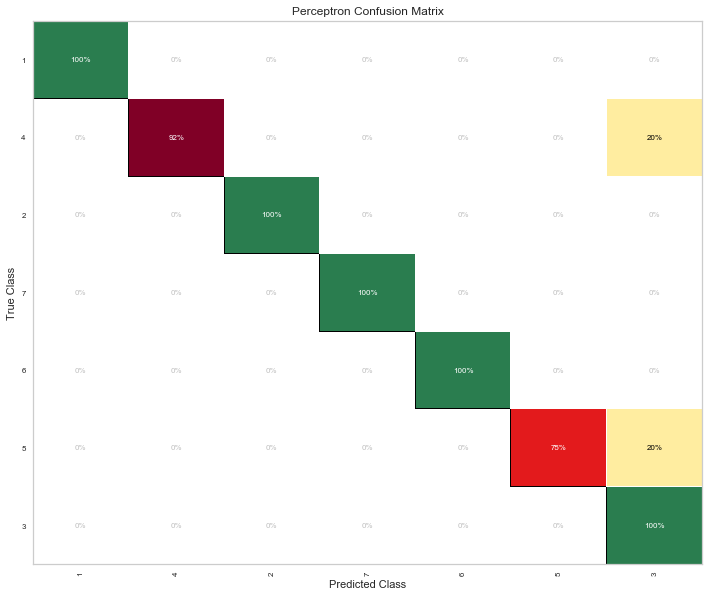

In [11]:
from sklearn.linear_model import Perceptron
from yellowbrick.classifier import ConfusionMatrix
perc = Perceptron(random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(perc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1), y).score(X.drop('animal_name', axis=1), y)
fig = cm.poof()

The confusion matrix shows us that our data is not linearly separable as it stands. We mistook a fish for a reptile and a reptile for an amphibian. The next step will be to try projecting our features into a higher dimensional space in which the data may be linearly separable, ie. run the data through a support vector machine.

## PCA Classifier

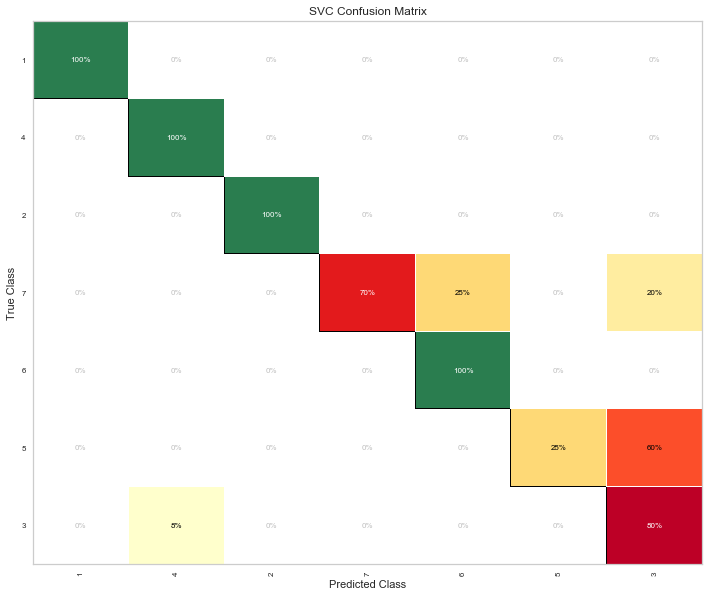

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pca_svc = make_pipeline(PCA(n_components=3), SVC(kernel='linear', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(pca_svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1), y).score(X.drop('animal_name', axis=1), y)
fig = cm.poof()

In [46]:
pca_svc.steps[0][1].explained_variance_ratio_

array([ 0.35056485,  0.18760977,  0.13405563])

In [47]:
bad = set()
for i,actual,pred in zip(X.index.values, y, pca_svc.predict(X.drop('animal_name', axis=1))):
    if actual != pred:
        bad.add(i)

The PCA approach doesn't look great. Let's try a regular support vector machine without any dimension reduction.

# Support Vector Machine

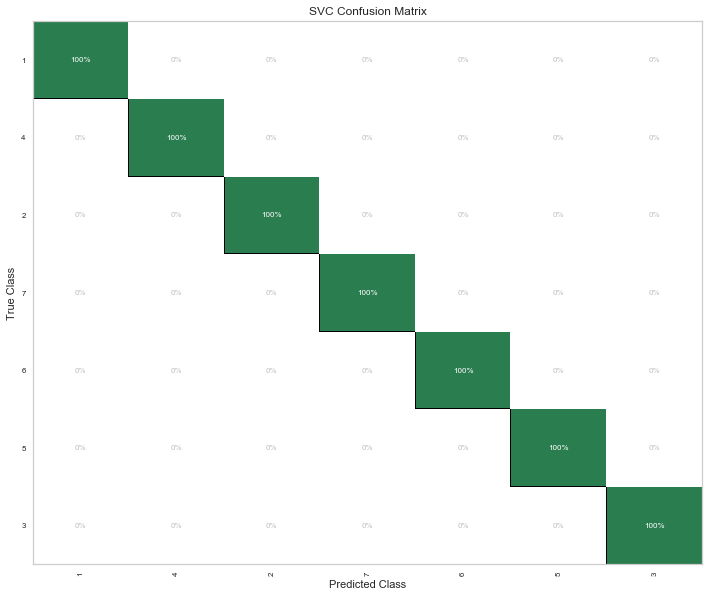

In [17]:
from sklearn.svm import SVC


svc = SVC(kernel='linear')

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1), y).score(X.drop('animal_name', axis=1), y)
fig = cm.poof()

Sweet baby jesus we've done it. We have linear separability!

# SVM Hyperparameter Tuning

Now that we know the dataset is linearly separable, let's cross-validate the model to find the optimal hyperparameters. Although we performed perfectly on all of the data with a linear kernel, other kernels might generalize better, so the hyperparameters of interest will be **C**, **gamma**, and **kernel**.

In [18]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop('animal_name', 1), y, stratify=y) 

Cs = [.001, .01, .1, 1, 10]
gammas = [.001, .01, .1, 1]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {'C':Cs, 'gamma':gammas, 'kernel':kernels}

n_folds = n_classes # Number of folds must be less than number of obs in smallest class
grid_search = GridSearchCV(SVC(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

C:\Users\samba\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=7.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=7, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
grid_search.best_params_

{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}

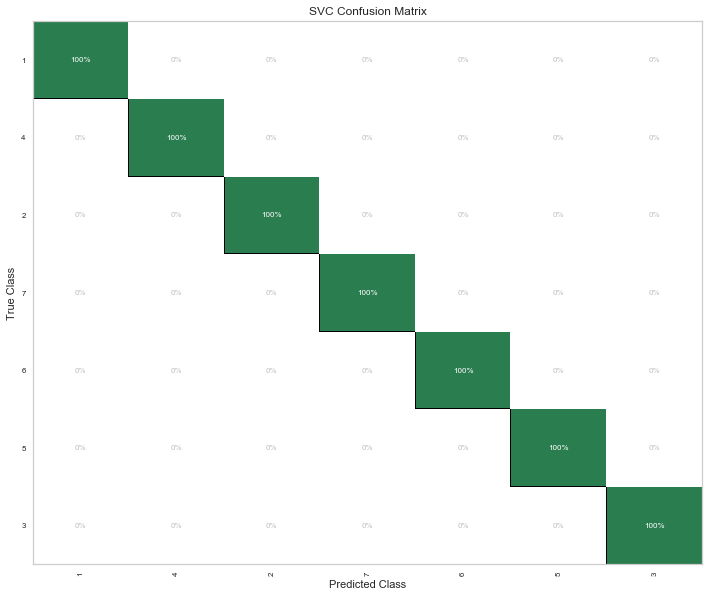

In [20]:
svc = SVC(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

### Recursive Feature Elimination

Let's see if any of our features are unnecessary... (have to use linear kernel to get coefficients)

In [21]:
from sklearn.feature_selection import RFECV

In [22]:
params = {'C': .1, 'gamma': 1, 'kernel': 'linear'}
svc = SVC(**params)

Alrighty then! It looks like my work here is done...we predicted test set perfectly. Based on the cross-validation, our optimal hyperparameters were a C of .1, gamma of 1, and polynomial kernel.

In [23]:
selector = RFECV(svc, step=1, cv=3)
selector = selector.fit(X.drop('animal_name', 1), y)

In [24]:
important_features = pd.Series(X.drop('animal_name', 1).columns)[selector.support_]

In [25]:
X[important_features]

,hair,feathers,eggs,milk,airborne,aquatic,toothed,backbone,breathes,fins,tail,2_legs,4_legs,6_legs
0,1,0,0,1,0,0,1,1,1,0,0,0,1,0
1,1,0,0,1,0,0,1,1,1,0,1,0,1,0
2,1,0,0,1,0,0,1,1,1,0,0,0,1,0
3,1,0,0,1,0,0,1,1,1,0,1,0,1,0
4,1,0,0,1,0,0,1,1,1,0,1,0,1,0
5,1,0,0,1,0,0,1,1,1,0,1,0,1,0
6,1,0,0,1,0,0,1,1,1,0,0,0,1,0
7,1,0,0,1,0,0,1,1,1,0,1,0,1,0
8,1,0,0,1,0,0,1,1,1,0,1,0,1,0
9,0,0,0,1,0,1,1,1,1,1,1,0,0,0


Let's try a support vector machine with only the import features....

In [26]:
params = {'C': .1, 'gamma': 1, 'kernel': 'linear'}
svc = SVC(**params).fit(X[important_features], y)
svc.score(X[important_features], y)

0.95049504950495045

Looks like we still got 100% on the full dataset!! That's a good sign. Let's see if we can get comparable accuracy with leave-one-out cross-validation.

In [27]:
def jackknife_cv(X, y, est='SVC'):
    est = est.lower()
    if est == 'svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'poly'}
        model = SVC(**params)
    elif est == 'bnb':
        params = {'alpha': 1, 'fit_prior': True}
        model = BernoulliNB(**params)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params)
    elif est == 'mlp':
        model = MLPClassifier()
    elif est == 'rf':
        model = RandomForestClassifier()
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
    
    scores = []
    wrong = []
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        if y_test[0] != model.predict(X_test)[0]:
            wrong.append(test_index[0])
    
    return scores, wrong

In [ ]:
wrong_dfs = []
for est in ['svc', 'bnb', 'knc', 'gbm']:
    scores, wrong = jackknife_cv(X[important_features], y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.iloc[wrong]))

In [132]:
for est,df in wrong_dfs:
    print(est)
    print(df)

svc
   animal_name class_name
97    seasnake    Reptile
99    tortoise    Reptile
bnb
   animal_name    class_name
79    scorpion  Invertebrate
94        newt     Amphibian
97    seasnake       Reptile
knc
   animal_name class_name
84        flea        Bug
90     termite        Bug
97    seasnake    Reptile
gbm
   animal_name    class_name
79    scorpion  Invertebrate
94        newt     Amphibian
97    seasnake       Reptile


### This is a big win!!! Both accuracies went up!!

# Naive Bayes Classifier

In [51]:
from sklearn.naive_bayes import BernoulliNB

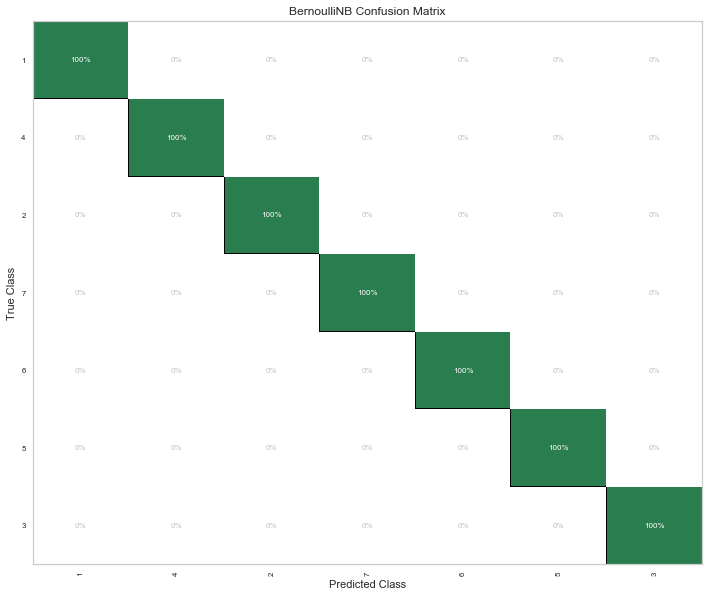

In [52]:
bnb = BernoulliNB()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(bnb, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

In [53]:
alphas = [.00001, .0001, .001, .01, .1, 1, 10]
fit_priors = [True, False]
param_grid = {'alpha': alphas, 'fit_prior': fit_priors}

n_folds = 3
grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [54]:
grid_search.best_params_

{'alpha': 1, 'fit_prior': True}

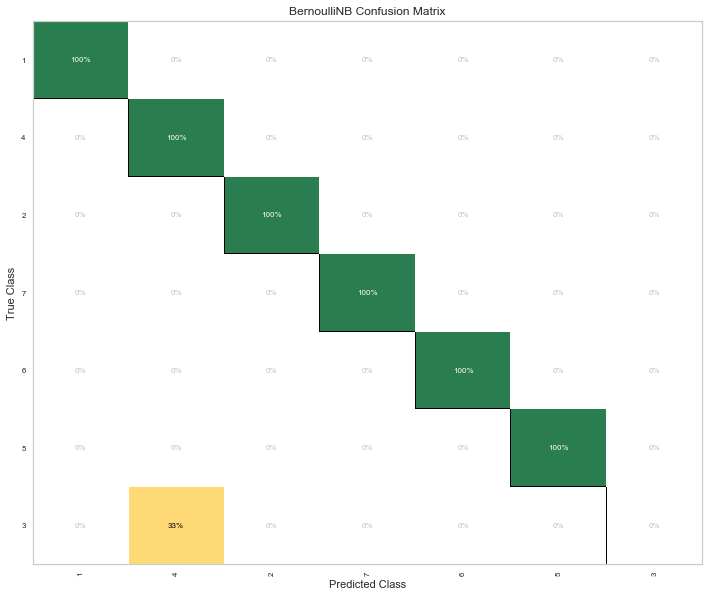

In [55]:
bnb = BernoulliNB(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(bnb, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

# K Nearest Neighbors Classifier

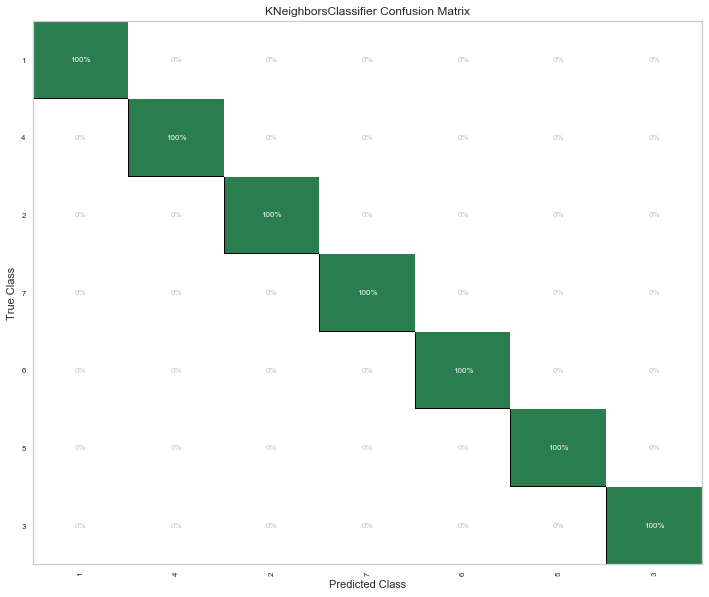

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(1)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

# K Nearest Neighbors Cross-validation

In [51]:
from sklearn.grid_search import GridSearchCV

n_neighbors = np.arange(4, 6)
metrics = ['euclidean', 'minkowski', 'jaccard', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath']
weights = ['uniform', 'distance']
param_grid = {'n_neighbors': n_neighbors, 'metric':metrics, 'weights':weights}


grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([4, 5]), 'metric': ['euclidean', 'minkowski', 'jaccard', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [52]:
grid_search.best_params_

{'metric': 'matching', 'n_neighbors': 4, 'weights': 'distance'}

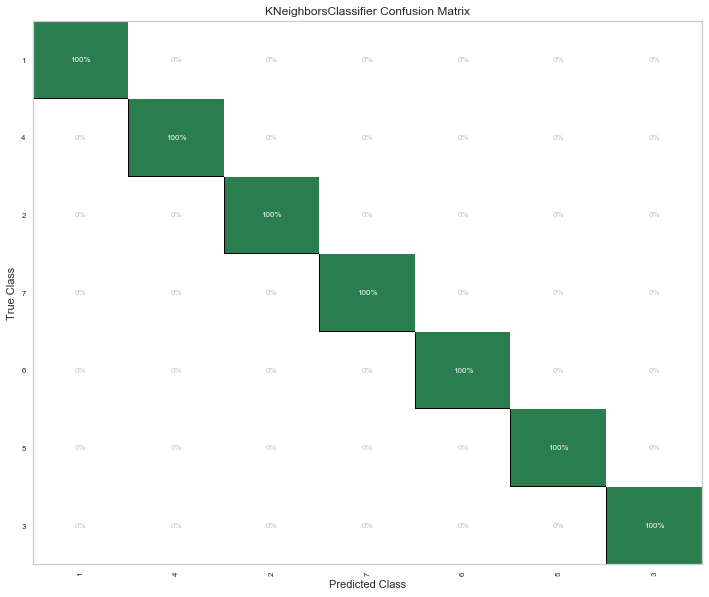

In [43]:
knc = KNeighborsClassifier(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

In [44]:
knc.score(X_test, y_test)

1.0

# Gradient Boosting Machine

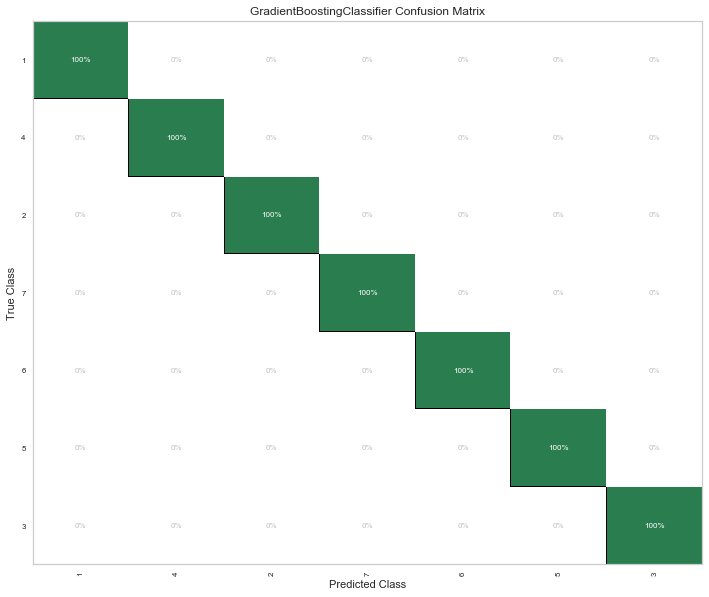

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

knc = GradientBoostingClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

In [60]:
# n_estimators = np.arange(20,81,10)
# max_depths = np.arange(5,16,2)
# min_samples_splits = np.arange(200,1001,200)
# max_features = np.arange(7,20,2)
# param_grid = {'n_estimators': n_estimators, 
#               'max_depth': max_depths, 
#               'min_samples_split': min_samples_splits, 
#               'max_features': max_features}

# grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=n_folds)
# grid_search.fit(X_train, y_train)

In [61]:
min_samples_splits = np.arange(20,31,5)
max_features = np.arange(16,21,1)
param_grid = {'min_samples_split': min_samples_splits, 
              'max_features': max_features}

grid_search = GridSearchCV(GradientBoostingClassifier(n_estimators=20, max_depth=5), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([20, 25, 30]), 'max_features': array([16, 17, 18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Multilayer Perceptron

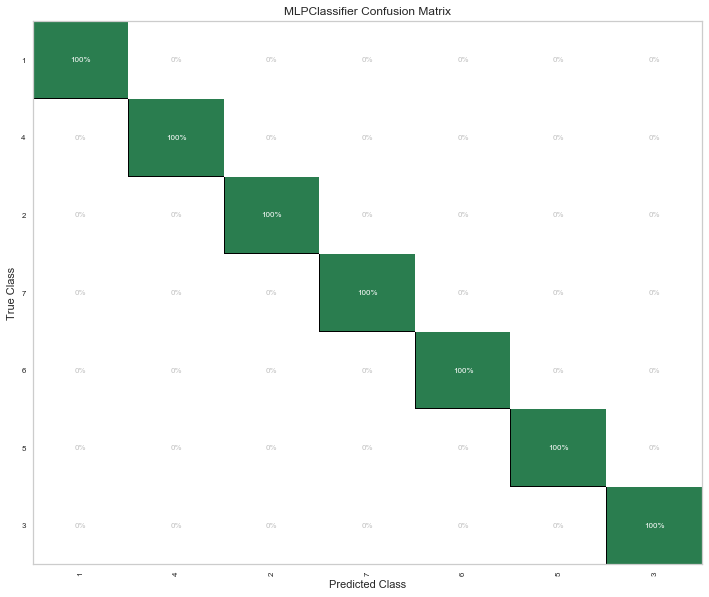

In [62]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

### TODO: Tune MLP Hyperparamters

In [63]:
param_grid = {}

grid_search = GridSearchCV(MLPerceptron(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

NameError: name 'MLPerceptron' is not defined

# Random Forest

Here we try a random forest, but in practice decision tree based apporaches tend not to perform well on small datasets (they overfit).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

mlp = RandomForestClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

### TODO: Tune Random Forest Hyperparameters

In [64]:
param_grid = {}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

NameError: name 'RandomForestClassifier' is not defined

# Testing

## GridSearch Cross-validation

Let's see if we just got lucky with our cross-validation by simulating a variety of random seeds for splitting the data into test and train.

In [65]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

def test_model(seed, est):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)
    if est == 'svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'poly'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'bnb':
        params = {'alpha': 1, 'fit_prior': True}
        model = BernoulliNB(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'mlp':
        model = MLPClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'rf':
        model = RandomForestClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
        
    for animal_name,actual,pred in zip(X_train.animal_name, y_test, model.predict(X_test.drop(['animal_name'], axis=1))):

        if actual != pred:
#             if est == 'svc':
#                 print(est)
            bad.append((est, animal_name))
    
    return model.score(X_test.drop(['animal_name'], axis=1), y_test)

In [66]:
def simulate_model(n_simulations, est):
    scores = []
    for seed in range(n_simulations):
        if seed % 100 == 0: print(seed)
        scores.append(test_model(seed, est.lower()))
    print('The average accuracy for ' + est.upper() + ' across {} simulations was {:.2%}'.format(n_simulations, np.mean(scores)))
    return scores

In [41]:
estimators = ['svc', 'bnb', 'knc', 'gbm']

In [42]:
bad = []
n_simulations = 1000
for est in estimators:
    scores = simulate_model(n_simulations, est)

0
100
200
300
400
500
600
700
800
900
The average accuracy for SVC across 1000 simulations was 97.43%
0
100
200
300
400
500
600
700
800
900
The average accuracy for BNB across 1000 simulations was 95.33%


| Model  | Accuracy  |
|:-------|----------:|
| SVC    | 97.57%    |
| KNC    | 95.10%    |
| GBM    | 97.42%    |
| MLP    | 96.47%    |
| RF     | 96.58%    |

### Jackknife Cross-Validation

Since our dataset is so small, we will try leave-one-out cross-validation. This can be thought of as k-fold cross-validation where k=n.

In [107]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

In [46]:
wrong_dfs = []

In [104]:
def jackknife_cv(X, y, est='SVC'):
    est = est.lower()
    if est == 'svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'poly'}
        model = SVC(**params)
    elif est == 'bnb':
        params = {'alpha': 1, 'fit_prior': True}
        model = BernoulliNB(**params)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params)
    elif est == 'mlp':
        model = MLPClassifier()
    elif est == 'rf':
        model = RandomForestClassifier()
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
    
    scores = []
    wrong = []
    for train_index, test_index in LeaveOneOut().split(X.drop('animal_name', 1)):
        X_train, X_test = X.drop('animal_name', 1).loc[train_index], X.drop('animal_name', 1).loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        if y_test[0] != model.predict(X_test)[0]:
            wrong.append(test_index[0])
    
    return scores, wrong

In [50]:
wrong_dfs = []
for est in estimators:
    scores, wrong = jackknife_cv(X, y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.iloc[wrong]))

The average accuracy for SVC with jackknife cross-validation was 97.03%.
The average accuracy for BNB with jackknife cross-validation was 94.06%.


## Which samples are difficult to predict?

In [227]:
bad_df = pd.DataFrame(bad, columns=['model', 'animal_name'])
bad_df = bad_df.merge(pd.DataFrame(animal_names), how='left')

In [233]:
animal_counts = pd.DataFrame(bad_df.groupby('model').animal_name.value_counts())
animal_counts.columns = ['cnt']
animal_counts = animal_counts.reset_index()
animal_counts = animal_counts.merge(animal_names)

animal_counts = animal_counts.sort_values(['model', 'cnt'], ascending=False)
animal_counts

,model,animal_name,cnt,class_name
14,svc,dove,17,Bird
4,svc,mongoose,15,Mammal
24,svc,ostrich,12,Bird
129,svc,lion,12,Mammal
19,svc,girl,11,Mammal
44,svc,bass,11,Fish
34,svc,flea,10,Bug
139,svc,pike,10,Fish
194,svc,porpoise,10,Mammal
254,svc,oryx,10,Mammal


In [ ]:
class_counts = pd.DataFrame(animal_names.groupby(['class_name']).count()).reset_index()
animal_counts = animal_counts.merge(class_counts, on='class_name', how='left', suffixes=('_animal', '_class'))

In [242]:
animal_counts.groupby('animal_name_animal').cnt.sum().sort_values(ascending=False)

animal_name_animal
mongoose    85
dove        79
pike        69
gnat        68
girl        66
carp        66
oryx        65
hare        64
ostrich     64
bass        63
hamster     63
antelope    63
chub        61
flea        61
slowworm    60
wallaby     59
stingray    59
pitviper    58
crayfish    58
tortoise    57
termite     57
lion        56
octopus     54
giraffe     54
porpoise    54
tuna        53
toad        52
duck        51
tuatara     51
parakeet    51
            ..
seal        42
newt        42
wren        41
seawasp     40
reindeer    40
honeybee    39
fruitbat    37
moth        37
piranha     37
skua        37
starfish    36
penguin     35
skimmer     35
rhea        35
opossum     35
lobster     34
swan        34
dolphin     34
vampire     33
herring     32
platypus    32
ladybird    32
pony        32
seahorse    30
mink        30
lark        30
wolf        30
crab        29
deer        24
bear        23
Name: cnt, Length: 101, dtype: int64

In [199]:
for est,df in wrong_dfs:
    print(est)
    print(df)

svc
   animal_name class_name
94        newt  Amphibian
97    seasnake    Reptile
99    tortoise    Reptile
knc
   animal_name    class_name
81        slug  Invertebrate
83        worm  Invertebrate
84        flea           Bug
90     termite           Bug
97    seasnake       Reptile
gbm
   animal_name    class_name
76    crayfish  Invertebrate
79    scorpion  Invertebrate
97    seasnake       Reptile
mlp
    animal_name class_name
94         newt  Amphibian
97     seasnake    Reptile
99     tortoise    Reptile
100     tuatara    Reptile
rf
   animal_name    class_name
26    platypus        Mammal
79    scorpion  Invertebrate
97    seasnake       Reptile
99    tortoise       Reptile


In [211]:
dfs = [df.reset_index() for _, df in wrong_dfs]

In [ ]:
wrong = pd.concat(dfs)

### Incorrect Predictions by Class

In [213]:
wrong.groupby('class_name').apply(lambda x: x.shape[0])

class_name
Amphibian       2
Bug             2
Invertebrate    5
Mammal          1
Reptile         9
dtype: int64

### Incorrect Predictions by Animal

In [214]:
wrong.groupby('animal_name').apply(lambda x: x.shape[0])

animal_name
crayfish    1
flea        1
newt        2
platypus    1
scorpion    2
seasnake    5
slug        1
termite     1
tortoise    3
tuatara     1
worm        1
dtype: int64

In [ ]:
4

# Find most similar animals with collaborative filtering